Để xây dựng mô hình Random Forest, trước hết, ta đưa vào môi trường làm việc các thư viện sau đây.

In [4]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
import pandas as pd
from scipy import stats
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV

Sau đó, ta thực hiện các công việc sau:
- Đọc các tập dữ liệu, sử dụng thư viện Pandas
- Chia tập dữ liệu ban đầu thành các tập train, validation và test.
- Thực hiện việc xây dựng mô hình RandomForest trên tập train và tính toán feature importance trên tập validation để tìm ra các thuộc tính có ảnh hưởng đến mô hình.
- Vẽ biểu đồ từ giá trị feature importance.

educ_center                                                        0
harass5_Does_not_apply_(i_do_not_have_a_job/superior/co-worker)    0
harass5_No                                                         0
harass5_Yes                                                        0
polviews_Conservative                                              0
polviews_Extremely_liberal                                         0
polviews_Extrmly_conservative                                      0
polviews_Liberal                                                   0
polviews_Moderate                                                  0
polviews_Slghtly_conservative                                      0
polviews_Slightly_liberal                                          0
advfront_Agree                                                     0
advfront_Disagree                                                  0
advfront_Dont_know                                                 0
advfront_Strongly_agree           

/tmp/ipykernel_80498/1648547772.py:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


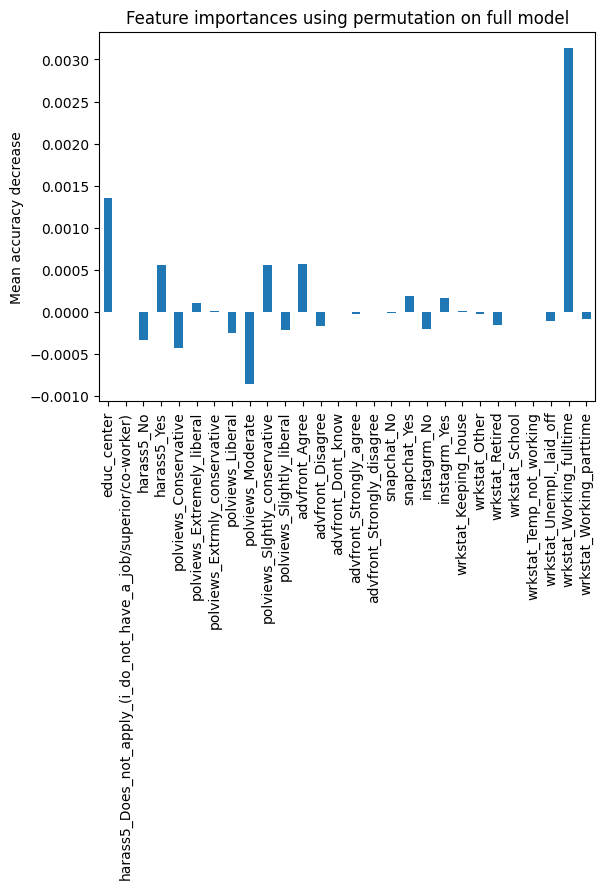

In [5]:

X = pd.read_csv("data/preprocessing/X.csv")
y = pd.read_csv("data/preprocessing/y.csv")["email_time_center"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train_2, X_val, y_train_2, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.isna().sum())

result_df = pd.DataFrame()

feature_names = list(X_train.columns)
forest = RandomForestRegressor(random_state=0)
forest.fit(X_train_2, y_train_2)

result = permutation_importance(
    forest, X_val, y_val, n_repeats=10, random_state=42, n_jobs=2,
    scoring=make_scorer(mean_squared_error, greater_is_better=False)
)

forest_importances = pd.Series(result.importances_mean, index=feature_names)

# Vẽ biểu đồ với cột tìm được.
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()


Qua đây, chúng ta tìm được các feature dưới đây có ảnh hưởng đến mô hình.

- wrkstat_Working fulltime
- educ_center
- harass5_Yes
- polviews_Slghtly conservative
- advfront_Agree

Tiếp theo, chúng ta xây dựng lại mô hình RandomForest, chỉ sử dụng các feature này và đi tìm tham số tối ưu cho mô hình. Các tham số cần tối ưu đó là:

- n_estimators: Số cây được xây dựng để tạo ra mô hình RandomForest.
- max_depth: Chiều cao tối đa của các cây trong mô hình.

In [6]:
# Thực hiện tìm tham số phù hợp.
# Thử xây dựng mô hình RandomForest với 5 feature có ảnh hưởng đến mô hình.
def tune_hyperparams(X_train, y_train, seed: int):
    distributions = dict(
        n_estimators=[128, 256, 512],
        max_depth=[2, 3, 4, 5],
    )
    forest = RandomForestRegressor(random_state=seed)
    clf = GridSearchCV(forest, distributions, 
                       scoring=make_scorer(mean_squared_error, greater_is_better=False))
    search = clf.fit(X_train, y_train)
    print(f"Best params: {search.best_params_}")
    print(f"Best score: {search.best_score_}")
    return search

top_feature_choice = [
    "wrkstat_Working_fulltime",
    "educ_center",
    "harass5_Yes",
    "polviews_Slghtly_conservative",
    "advfront_Agree"
]


for i in range(1, len(top_feature_choice)):
    X_top_feature = X[top_feature_choice[:i]]
    X_train, X_test, y_train, y_test = train_test_split(X_top_feature, y, random_state=42)
    print(f"Feature: {top_feature_choice[:i]}")
    tune_hyperparams(X_train, y_train, i)

# Nhận xét: Chọn 2 feature đầu là hợp lý nhất.

Feature: ['wrkstat_Working_fulltime']
Best params: {'max_depth': 2, 'n_estimators': 256}
Best score: -0.01180161917798789
Feature: ['wrkstat_Working_fulltime', 'educ_center']
Best params: {'max_depth': 2, 'n_estimators': 512}
Best score: -0.011412424168543763
Feature: ['wrkstat_Working_fulltime', 'educ_center', 'harass5_Yes']
Best params: {'max_depth': 2, 'n_estimators': 512}
Best score: -0.011434192981868563
Feature: ['wrkstat_Working_fulltime', 'educ_center', 'harass5_Yes', 'polviews_Slghtly_conservative']
Best params: {'max_depth': 2, 'n_estimators': 128}
Best score: -0.011426502668499759


Với kết quả thu được ở trên, chúng ta thấy rằng mô hình tốt nhất sẽ bao gồm các thuộc tính: "wrkstat_Working fulltime" và "educ_center", với các tham số tương ứng là: max_depth = 2, n_estimators = 512

Cuối cùng, chúng ta xây dựng mô hình dựa trên các feature tốt nhất và các tham số tốt nhất tương ứng, sau đó thực hiện việc tính MSE và RMSE trên tập test.

In [9]:
from sklearn.metrics import r2_score

y_pred = None

# Build mô hình cuối cùng, test và in kết quả.
def final_model(X_train, y_train, X_test, y_test, seed: int):
    global y_pred
    forest = RandomForestRegressor(random_state=seed, max_depth=2, n_estimators=512)
    forest.fit(X_train, y_train)
    y_pred = forest.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    print(f"Test MSE: {mse}")
    print(f"Test RMSE: {rmse}")
    print(f'Test R2 score: {r2}')

feature_choice = [
    'wrkstat_Working_fulltime', 'educ_center'
]
X = X[feature_choice]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
print(f"Feature: {feature_choice}")
final_model(X_train, y_train, X_test, y_test, 0)

Feature: ['wrkstat_Working_fulltime', 'educ_center']
Test MSE: 0.012402495973343317
Test RMSE: 0.11136649394383985
Test R2 score: 0.08526301927730695


array([[<Axes: title={'center': '0'}>]], dtype=object)

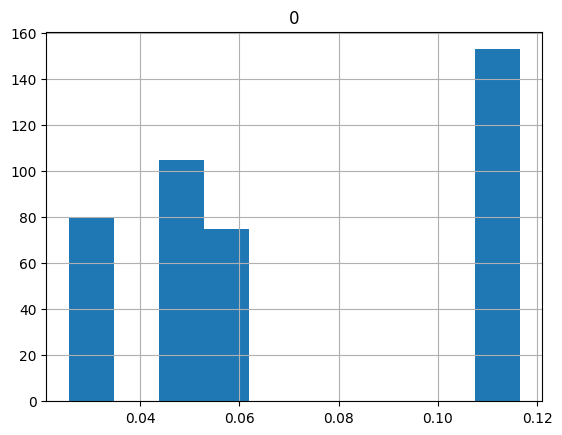

In [8]:
pd.DataFrame(y_pred).hist()